In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

# import torch
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Good data
# df = pd.read_csv('./data/kokil dec 6 reprepare/affcon_final_with_linguistics.csv')

In [3]:
# Messy data
# df = pd.read_csv('./data/affcon_final_politeness_strategies_merge.csv')

In [4]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')

In [5]:
df = df.dropna()

In [6]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


Plot old throughput (x-axis) vs new throughput (y-axis)


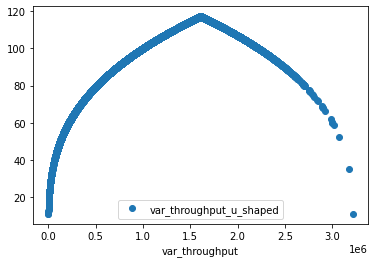

In [7]:
# # Throughput (weighted by variance)
# df_throughput = df[['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5']].copy()
# df_throughput['var_throughput'] = df_throughput.var(axis=1)
# print("Plot old throughput (x-axis) vs new throughput (y-axis)")
# plt.plot(df_throughput['var_throughput'], df_throughput['var_throughput'])
# df_throughput['var_throughput'] = df_throughput['var_throughput'] / df_throughput['var_throughput'].max()

# Throughput (weighted by inverted V-shape variance)
df_throughput = df[['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5']].copy()
df_throughput['var_throughput'] = df_throughput.var(axis=1)
max_val = df_throughput['var_throughput'].max()
min_val = df_throughput['var_throughput'].min()
tp_mid = ((max_val - min_val) // 2) + min_val
tp_to_list = df_throughput['var_throughput'].tolist()

amount_of_curve = 3

u_shaped_variance = []
for each in tp_to_list:
    if each > tp_mid:
        u_shaped_variance.append((2*tp_mid - each)**(1/amount_of_curve))
    else:
        u_shaped_variance.append(each**(1/amount_of_curve))
        
df_throughput['var_throughput_u_shaped'] = u_shaped_variance
print("Plot old throughput (x-axis) vs new throughput (y-axis)")
df_throughput.plot(x='var_throughput', y='var_throughput_u_shaped', style='o')
df_throughput['var_throughput_u_shaped'] = df_throughput['var_throughput_u_shaped'] / df_throughput['var_throughput_u_shaped'].max()
df_throughput = df_throughput.assign(var_throughput=df_throughput['var_throughput_u_shaped'])

# WorkTime (weighted by variance)
df_worktime = df[['WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5']].copy()
df_worktime['var_worktime'] = df_worktime.var(axis=1)
df_worktime['var_worktime'] = df_worktime['var_worktime'] / df_worktime['var_worktime'].max()

# Percentage Agreement
df_agreement = df[['Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 'Answer.3rapport.yes_pc_agree']]

In [8]:
df_throughput

,Throughput.1,Throughput.2,Throughput.3,Throughput.4,Throughput.5,var_throughput,var_throughput_u_shaped
5,390,2331,193,2139,162.0,0.905919,0.905919
6,234,2134,2331,1022,1411.0,0.767038,0.767038
7,521,2139,2660,1411,892.0,0.782763,0.782763
8,2632,2415,1482,892,3747.0,0.909788,0.909788
9,2905,95,528,892,300.0,0.928787,0.928787
...,...,...,...,...,...,...,...
13189,1168,2632,2415,19,2139.0,0.899110,0.899110
13190,1252,501,13,390,408.0,0.503678,0.503678
13191,575,1252,2660,1601,1014.0,0.727428,0.727428
13192,251,390,331,528,297.0,0.192362,0.192362


In [9]:
indices = range(df.shape[0])

### Individual Classifiers are LSTMS

In [10]:
train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
le = LabelEncoder()

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

# tok.fit_on_texts(X_test_col)
X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.00001)
def create_lstm():
    Inp = Input(name='inputs', shape=[max_len])
    x = Embedding(max_words, 50, input_length=max_len)(Inp)
    x = LSTM(64, name='LSTM_01')(x)
    x = Dropout(0.5, name='Dropout')(x)
    x = Dense(128, activation='relu',name='Dense_01')(x)
    # x = Dropout(0.5,name='Dropout')(x)
    out = Dense(1,activation='sigmoid', name='output')(x)
    model = Model(inputs=Inp, outputs=out)
    
    return model

### Construct individual LSTM models

In [15]:
# Rapport model
rapport_model = create_lstm()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
rapport_model.fit(X_train,y_train_rapport,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_rapport), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 26ms/step - loss: 0.4274 - accuracy: 0.8586 - f1_m: 0.9236 - recall_m: 0.9938 - precision_m: 0.8651 - val_loss: 0.4171 - val_accuracy: 0.8624 - val_f1_m: 0.9263 - val_recall_m: 1.0000 - val_precision_m: 0.8632
Epoch 2/15
72/72 [==============================] - 2s 23ms/step - loss: 0.4047 - accuracy: 0.8626 - f1_m: 0.9250 - recall_m: 1.0000 - precision_m: 0.8611 - val_loss: 0.4037 - val_accuracy: 0.8624 - val_f1_m: 0.9263 - val_recall_m: 1.0000 - val_precision_m: 0.8632
Epoch 3/15
72/72 [==============================] - 1s 21ms/step - loss: 0.4011 - accuracy: 0.8626 - f1_m: 0.9250 - recall_m: 1.0000 - precision_m: 0.8611 - val_loss: 0.4132 - val_accuracy: 0.8624 - val_f1_m: 0.9263 - val_recall_m: 1.0000 - val_precision_m: 0.8632


In [16]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

In [17]:
rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.43117854001759015, 0.5, 0.4630460448642267, None)

In [18]:
# Game move model
gamemove_model = create_lstm()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
gamemove_model.fit(X_train,y_train_gamemove,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_gamemove), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 24ms/step - loss: 0.2755 - accuracy: 0.9310 - f1_m: 0.9645 - recall_m: 0.9979 - precision_m: 0.9338 - val_loss: 0.2864 - val_accuracy: 0.9235 - val_f1_m: 0.9604 - val_recall_m: 1.0000 - val_precision_m: 0.9241
Epoch 2/15
72/72 [==============================] - 2s 23ms/step - loss: 0.2509 - accuracy: 0.9326 - f1_m: 0.9655 - recall_m: 1.0000 - precision_m: 0.9335 - val_loss: 0.2804 - val_accuracy: 0.9235 - val_f1_m: 0.9604 - val_recall_m: 1.0000 - val_precision_m: 0.9241
Epoch 3/15
72/72 [==============================] - 2s 23ms/step - loss: 0.2448 - accuracy: 0.9326 - f1_m: 0.9655 - recall_m: 1.0000 - precision_m: 0.9335 - val_loss: 0.3493 - val_accuracy: 0.9235 - val_f1_m: 0.9604 - val_recall_m: 1.0000 - val_precision_m: 0.9241


In [19]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

In [20]:
gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.46174142480211083, 0.5, 0.48010973936899864, None)

In [21]:
# Reasoning model
reasoning_model = create_lstm()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
reasoning_model.fit(X_train,y_train_reasoning,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_reasoning), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 25ms/step - loss: 0.4837 - accuracy: 0.8213 - f1_m: 0.9003 - recall_m: 0.9906 - precision_m: 0.8283 - val_loss: 0.5077 - val_accuracy: 0.8386 - val_f1_m: 0.9118 - val_recall_m: 1.0000 - val_precision_m: 0.8387
Epoch 2/15
72/72 [==============================] - 1s 19ms/step - loss: 0.4664 - accuracy: 0.8269 - f1_m: 0.9062 - recall_m: 1.0000 - precision_m: 0.8292 - val_loss: 0.4870 - val_accuracy: 0.8386 - val_f1_m: 0.9118 - val_recall_m: 1.0000 - val_precision_m: 0.8387
Epoch 3/15
72/72 [==============================] - 2s 21ms/step - loss: 0.4586 - accuracy: 0.8269 - f1_m: 0.9043 - recall_m: 1.0000 - precision_m: 0.8258 - val_loss: 0.4518 - val_accuracy: 0.8386 - val_f1_m: 0.9118 - val_recall_m: 1.0000 - val_precision_m: 0.8387
Epoch 4/15
72/72 [==============================] - 2s 21ms/step - loss: 0.4454 - accuracy: 0.8269 - f1_m: 0.9062 - recall_m: 1.0000 - precision_m: 0.8292 - val_loss: 0.4592 - val_accuracy: 0.8386 - val_f1

In [22]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

In [23]:
reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.4193051890941073, 0.5, 0.45611097823487207, None)

In [24]:
# Share Information model
shareinfo_model = create_lstm()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
shareinfo_model.fit(X_train,y_train_share_information,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_share_information), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 24ms/step - loss: 0.4634 - accuracy: 0.8401 - f1_m: 0.9121 - recall_m: 0.9996 - precision_m: 0.8391 - val_loss: 0.4653 - val_accuracy: 0.8412 - val_f1_m: 0.9134 - val_recall_m: 1.0000 - val_precision_m: 0.8409
Epoch 2/15
72/72 [==============================] - 1s 21ms/step - loss: 0.4425 - accuracy: 0.8404 - f1_m: 0.9141 - recall_m: 1.0000 - precision_m: 0.8426 - val_loss: 0.5101 - val_accuracy: 0.8412 - val_f1_m: 0.9134 - val_recall_m: 1.0000 - val_precision_m: 0.8409


In [25]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

In [26]:
shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.42062445030782764, 0.5, 0.45689037497014573, None)

In [27]:
# Deception model
deception_model = create_lstm()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
deception_model.fit(X_train,y_train_deception,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_deception), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 27ms/step - loss: 0.2255 - accuracy: 0.9446 - f1_m: 0.9706 - recall_m: 0.9928 - precision_m: 0.9519 - val_loss: 0.2035 - val_accuracy: 0.9485 - val_f1_m: 0.9736 - val_recall_m: 1.0000 - val_precision_m: 0.9488
Epoch 2/15
72/72 [==============================] - 1s 20ms/step - loss: 0.1993 - accuracy: 0.9515 - f1_m: 0.9754 - recall_m: 1.0000 - precision_m: 0.9521 - val_loss: 0.2025 - val_accuracy: 0.9485 - val_f1_m: 0.9736 - val_recall_m: 1.0000 - val_precision_m: 0.9488
Epoch 3/15
72/72 [==============================] - 2s 21ms/step - loss: 0.1923 - accuracy: 0.9515 - f1_m: 0.9735 - recall_m: 1.0000 - precision_m: 0.9488 - val_loss: 0.2060 - val_accuracy: 0.9485 - val_f1_m: 0.9736 - val_recall_m: 1.0000 - val_precision_m: 0.9488


In [28]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.4742744063324538, 0.5, 0.48679756262694657, None)

### One hot encodings

In [29]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [30]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [31]:
def create_joint_model(df):
    inputB = Input(shape=(df.shape[1],))
    c = Dense(2, activation='relu')(inputB)
    c = Dense(4, activation='relu')(c)
    c = Dense(1, activation='softmax')(c)
    full_model = Model(inputs=inputB, outputs=c)

    full_model.compile(loss='binary_crossentropy', optimizer='adam', 
                          metrics=['acc',f1_m,precision_m, recall_m])
    
    return full_model

In [32]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df_full,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7397 - acc: 0.9515 - f1_m: 0.9751 - precision_m: 0.9518 - recall_m: 1.0000 - val_loss: 0.7846 - val_acc: 0.9485 - val_

In [33]:
joint_predict = joint_full_model.predict(pred_test_df_full)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.025725593667546173, 0.5, 0.04893350062735258, None)

In [34]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0948 - acc: 0.8626 - f1_m: 0.9261 - precision_m: 0.8635 - recall_m: 1.0000 - val_loss: 2.0989 - val_acc: 0.8624 - val_f1

In [35]:
joint_predict = joint_full_model.predict(pred_test_df)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06882145998240985, 0.5, 0.12098956320061847, None)

### Joint Model by Keras Concatenate

In [36]:
def create_concatenate_keras_model(models_arr):
    commonInput = Input(shape=[max_len])

    input_model_arr = []
    for model in models_arr: 
        outmodel = model(commonInput)
        input_model_arr.append(outmodel)
    
    mergedOut = Concatenate()(input_model_arr)

    mergedOut = Flatten()(mergedOut)    
    mergedOut = Dense(256, activation='relu')(mergedOut)
    mergedOut = Dropout(.5)(mergedOut)
    mergedOut = Dense(128, activation='relu')(mergedOut)
    mergedOut = Dropout(.35)(mergedOut)
    mergedOut = Dense(1, activation='softmax')(mergedOut)  #Cuz binary

    mergedModel = Model(commonInput, mergedOut)
    mergedModel.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy', f1_m, recall_m, precision_m])
    
    return mergedModel

In [37]:
print('Joint model by concatenate, predicting deception')
merged_model = create_concatenate_keras_model([gamemove_model, reasoning_model, shareinfo_model, rapport_model])
merged_model.summary()
merged_model.fit(X_train,y_train_deception,
          batch_size=128,
          epochs=15,
          validation_data=(X_test,y_test_deception), callbacks=[early_stop])

Joint model by concatenate, predicting deception
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 220)]        0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            87889       input_3[0][0]                    
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 1)            87889       input_3[0][0]                    
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 1)            87889       input_3[0][0]                    
_____________________________________

In [38]:
print('Joint model by concatenate, predicting rapport')
merged_model = create_concatenate_keras_model([gamemove_model, reasoning_model, shareinfo_model])
merged_model.summary()
merged_model.fit(X_train,y_train_rapport,
          batch_size=128,
          epochs=15,
          validation_data=(X_test,y_test_rapport), callbacks=[early_stop])

Joint model by concatenate, predicting rapport
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 220)]        0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            87889       input_4[0][0]                    
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 1)            87889       input_4[0][0]                    
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 1)            87889       input_4[0][0]                    
_______________________________________

## Weighted against Throughput, WorkTime, & PC Agreement

In [39]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()

throughput_values = df_throughput['var_throughput'].take(indices_train).values
pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

worktime_values = df_worktime['var_worktime'].take(indices_train).values
pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

agreement_values = df_agreement.take(indices_train)
pred_df_full_agreement = np.multiply(pred_df_full_throughput, agreement_values)
agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
pred_df_agreement = np.multiply(pred_df_throughput, agreement_values_wo_rapport)

In [40]:
pred_df_agreement.head()

,gamemove,reasoning,shareinfo
0,0.694944,0.624336,0.529629
1,0.756293,0.576350,0.581992
2,0.685997,0.469354,0.821573
3,0.673292,0.598521,0.648484
4,0.747960,0.354421,0.720138


In [41]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()

throughput_values_test = df_throughput['var_throughput'].take(indices_test).values
pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

worktime_values_test = df_worktime['var_worktime'].take(indices_test).values
pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

agreement_values_test = df_agreement.take(indices_test)
pred_df_full_agreement_test = np.multiply(pred_df_full_throughput_test, agreement_values_test)
agreement_values_wo_rapport_test = agreement_values_test.drop(columns=['Answer.3rapport.yes_pc_agree'])
pred_df_agreement_test = np.multiply(pred_df_throughput_test, agreement_values_wo_rapport_test)

## Throughput only

### Joint Model with one hot encoding 

In [42]:
def create_joint_model(df):
    inputB = Input(shape=(df.shape[1],))
    c = Dense(2, activation='relu')(inputB)
    c = Dense(4, activation='relu')(c)
    c = Dense(1, activation='softmax')(c)
    full_model = Model(inputs=inputB, outputs=c)

    full_model.compile(loss='binary_crossentropy', optimizer='adam', 
                          metrics=['acc',f1_m,precision_m, recall_m])
    
    return full_model

In [43]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_throughput_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7397 - acc: 0.9515 - f1_m: 0.9742 - precision_m: 0.9502 - recall_m: 1.0000 - val_loss: 0.7846 

In [44]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.025725593667546173, 0.5, 0.04893350062735258, None)

In [45]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [46]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_throughput_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0948 - acc: 0.8626 - f1_m: 0.9253 - precision_m: 0.8619 - recall_m: 1.0000 - val_loss: 2.0989 - 

In [47]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06882145998240985, 0.5, 0.12098956320061847, None)

## PC Agreement only

### Joint Model with one hot encoding 

In [48]:
def create_joint_model(df):
    inputB = Input(shape=(df.shape[1],))
    c = Dense(2, activation='relu')(inputB)
    c = Dense(4, activation='relu')(c)
    c = Dense(1, activation='softmax')(c)
    full_model = Model(inputs=inputB, outputs=c)

    full_model.compile(loss='binary_crossentropy', optimizer='adam', 
                          metrics=['acc',f1_m,precision_m, recall_m])
    
    return full_model

In [49]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_agreement_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7397 - acc: 0.9515 - f1_m: 0.9742 - precision_m: 0.9502 - recall_m: 1.0000 - val_loss: 0.784

In [50]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)


In [51]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_agreement_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0948 - acc: 0.8626 - f1_m: 0.9253 - precision_m: 0.8619 - recall_m: 1.0000 - val_loss: 2.0989 

## WorkTime only

### Joint Model with one hot encoding 

In [52]:
def create_joint_model(df):
    inputB = Input(shape=(df.shape[1],))
    c = Dense(2, activation='relu')(inputB)
    c = Dense(4, activation='relu')(c)
    c = Dense(1, activation='softmax')(c)
    full_model = Model(inputs=inputB, outputs=c)

    full_model.compile(loss='binary_crossentropy', optimizer='adam', 
                          metrics=['acc',f1_m,precision_m, recall_m])
    
    return full_model

In [53]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_worktime_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 0.7397 - acc: 0.9515 - f1_m: 0.9751 - precision_m: 0.9518 - recall_m: 1.0000 - val_loss: 0.7846 

In [54]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)


In [55]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_worktime_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 0s 3ms/step - loss: 2.0948 - acc: 0.8626 - f1_m: 0.9262 - precision_m: 0.8635 - recall_m: 1.0000 - val_loss: 2.0989 - 